In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv


# <h1 style = "font-size:60px"> üß† **STROKE PREDICTION** </h1>

# 1. Introduction
## 1.1 Context

* According to the World Health Organization (WHO), stroke is the second leading cause of death worldwide, responsible for approximately 11% of all deaths.

* A stroke occurs when the blood supply to part of the brain is cut off or reduced, preventing the brain tissue from receiving oxygen and nutrients.

* A stroke occurs when the blood supply to the brain is cut off or reduced, preventing brain tissue from receiving oxygen and nutrients, so brain cells begin to die within minutes.

* A stroke is a medical emergency and prompt treatment is crucial. Early action can reduce brain damage and other complications.

* This data set is used to predict whether a patient is likely to have a stroke based on input parameters such as gender, age, various diseases, and smoking status. Each row of data provides relevant information about the patient.

## 1.2 Problem Statement

* Improper treatment of people likely to have a stroke can have serious health consequences, including brain damage and death.

## 1.3 Objective

* Understand what are the reasons that cause a stroke in people.
* Visualize the relationships between various healthy and unhealthy habits for stroke.
* Predict the probability of stroke with the best model and hyperfit parameters.

## 1.4  Available Features

**Target**
1. `stroke` - 1 if the patient had a stroke or 0 if not.


**Clinical features for predicting stroke events:**

1. `id` - Unique identifier.
1. `gender` - "Male", "Female" or "Other".
1. `age` - Age of the patient.
1. `hypertension` - 0 if the patient doesn't have hypertension, 1 if the patient has hypertension.
1. `heart_disease` - 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease.
1. `ever_married` - "No" or "Yes".
1. `work_type` - "Children", "Govt_jov", "Never_worked", "Private" or "Self-employed".
1. `Residence_type` - "Rural" or "Urban".
1. `avg_glucose_level` - Average glucose level in blood.
1. `bmi` - Body mass index.
1. `smoking_status` - "formerly smoked", "never smoked", "smokes" or "Unknown".


## 1.5 Assumptions

1. Advancing Age is a significant risk factor for the development of a Stroke.
1. Patients with an advanced age and with a BMI have a higher risk of having Stroke.
1. Smokers with a high BMI have a higher risk of having a Stroke.
1. Patients with hypertension and heart disease are more likely to have a Stroke compared to those without these conditions.
1. Patients with elevated blood glucose levels have a higher risk of suffering a stroke compared to those with normal blood glucose levels.
1. People who live in urban areas are at higher risk of having a Stroke than those who live in rural areas.
1. Married men are at higher risk of having a Stroke than those who are not married.

___
# 2. Pre-requisites and Utilities
## 2.1 Libraries

In [2]:
# Data Manipulation.
import pandas as pd
import numpy as np

# Data Visualization.
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

# Dimencionality Reduction.
from sklearn.decomposition import PCA

# Warnings.
import warnings
warnings.filterwarnings("ignore")

# Palette of Colors
palette = sns.husl_palette(h=.5)
palette_matrix = sns.color_palette("light:#5A9", as_cmap=True)

## 2.2 Auxiliary Functions

In [3]:
# Create a DF with the revision of the data (value count, type, null, infinity).
def df_revision(df):
    col_values_count = {i:df[i].value_counts().shape[0] for i in df.columns}
    col_dtype = {i:df[i].dtype for i in df.columns}
    col_isObj = {i:('‚úÖ' if df[i].dtype in ['object', 'string'] else '-') for i in df.columns}
    col_na = {i:('‚úÖ' if df[i].isna().any() == True else '-') for i in df.columns}
    col_inf = {i:('‚úÖ' if df[i].isin([np.inf, - np.inf]).any() == True else '-') for i in df.columns}
    
    df_revision = pd.DataFrame([col_values_count, col_dtype, col_isObj, col_na, col_inf], index=['Values_Count', 'DType','Is_Obj', 'NA', 'inf']).transpose()
    return df_revision

___
# 3. Data Wrangling

## 3.1 Data Load



In [4]:
# The data is converted to a dataframe
df_original = pd.read_csv('/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv')

# Main dataframe is created
df = df_original.copy()

# Dataframe is created for EDA (Assumptions)
df_eda = df_original.copy()

## 3.2 Descriptive Analysis

### 3.2.1 Data View

In [5]:
df

id  gender   age  hypertension  heart_disease ever_married  \
0      9046    Male  67.0             0              1          Yes   
1     51676  Female  61.0             0              0          Yes   
2     31112    Male  80.0             0              1          Yes   
3     60182  Female  49.0             0              0          Yes   
4      1665  Female  79.0             1              0          Yes   
...     ...     ...   ...           ...            ...          ...   
5105  18234  Female  80.0             1              0          Yes   
5106  44873  Female  81.0             0              0          Yes   
5107  19723  Female  35.0             0              0          Yes   
5108  37544    Male  51.0             0              0          Yes   
5109  44679  Female  44.0             0              0          Yes   

          work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0           Private          Urban             228.69  36.6  formerly smoked   
1     Self-employed          Rural             202.21   NaN     never smoked   
2           Private          Rural             105.92  32.5     never smoked   
3           Private          Urban             171.23  34.4           smokes   
4     Self-employed          Rural             174.12  24.0     never smoked   
...             ...            ...                ...   ...              ...   
5105        Private          Urban              83.75   NaN     never smoked   
5106  Self-employed          Urban             125.20  40.0     never smoked   
5107  Self-employed          Rural              82.99  30.6     never smoked   
5108        Private          Rural             166.29  25.6  formerly smoked   
5109       Govt_job          Urban              85.28  26.2          Unknown   

      stroke  
0          1  
1          1  
2          1  
3          1  
4          1  
...      ...  
5105       0  
5106       0  
5107       0  
5108       0  
5109       0  

[5110 rows x 12 columns]

### 3.2.2 Statistics of Categorical and Numerical Data

In [6]:
# You get statistical insights
df.describe(include='all').fillna('-').round(1)

id  gender        age hypertension heart_disease  \
count         5110.0    5110     5110.0       5110.0        5110.0   
unique             -       3          -            -             -   
top                -  Female          -            -             -   
freq               -    2994          -            -             -   
mean    36517.829354       -  43.226614     0.097456      0.054012   
std     21161.721625       -  22.612647     0.296607      0.226063   
min             67.0       -       0.08          0.0           0.0   
25%         17741.25       -       25.0          0.0           0.0   
50%          36932.0       -       45.0          0.0           0.0   
75%          54682.0       -       61.0          0.0           0.0   
max          72940.0       -       82.0          1.0           1.0   

       ever_married work_type Residence_type avg_glucose_level        bmi  \
count          5110      5110           5110            5110.0     4909.0   
unique            2         5              2                 -          -   
top             Yes   Private          Urban                 -          -   
freq           3353      2925           2596                 -          -   
mean              -         -              -        106.147677  28.893237   
std               -         -              -          45.28356   7.854067   
min               -         -              -             55.12       10.3   
25%               -         -              -            77.245       23.5   
50%               -         -              -            91.885       28.1   
75%               -         -              -            114.09       33.1   
max               -         -              -            271.74       97.6   

       smoking_status    stroke  
count            5110    5110.0  
unique              4         -  
top      never smoked         -  
freq             1892         -  
mean                -  0.048728  
std                 -   0.21532  
min                 -       0.0  
25%                 -       0.0  
50%                 -       0.0  
75%                 -       0.0  
max                 -       1.0

<div class="alert alert-success" role="alert">
  <p> üîé In all the characteristics there are 5,110 copies except the characteristic "bmi".</p>
  <p> üîé The scales in the numerical characteristics are very different. </p>
  <p> üîé The dispersion of the data in characteristics such as "age" and "Glucose level is high.</p>
  <p> </p>
</div>

### 3.2.3 Data Revision

In [7]:
# The 'df revision' auxiliary function is used.
df_revision(df)

Values_Count    DType Is_Obj NA inf
id                        5110    int64      -  -   -
gender                       3   object      ‚úÖ  -   -
age                        104  float64      -  -   -
hypertension                 2    int64      -  -   -
heart_disease                2    int64      -  -   -
ever_married                 2   object      ‚úÖ  -   -
work_type                    5   object      ‚úÖ  -   -
Residence_type               2   object      ‚úÖ  -   -
avg_glucose_level         3979  float64      -  -   -
bmi                        418  float64      -  ‚úÖ   -
smoking_status               4   object      ‚úÖ  -   -
stroke                       2    int64      -  -   -

<div class="alert alert-success" role="alert">
  <p> üîé The "id" feature does not add value in the analysis because it is different for each instance.</p>
  <p> üîé We have categorical features that will have to be coded for analysis.</p>
  <p> üîé The characteristic "bmi" has null values.</p>
  <p> üîé The data does not contain infinite values.</p>
  <p> </p>
</div>

### 3.2.4 Count Values of Target 

In [8]:
# Dataframe with count of Target values.
stroke_count = pd.DataFrame(df['stroke'].value_counts()).rename({'stroke':'Count'}, axis=1)
stroke_percent = ((pd.DataFrame(df['stroke'].value_counts())/len(df))*100).round(2).rename({'stroke':'%'}, axis=1)

# Target Value Count DataFrame is created.
stroke = pd.concat([stroke_count, stroke_percent], axis=1)
stroke

Count      %
0   4861  95.13
1    249   4.87

<div class="alert alert-success" role="alert">
  <p> üîé We have data with a high level of imbalance.</p>
  <p> üîé 95% of patients have not had a stroke.</p>
  <p> üîé Only 5% of patients in the entire dataset have had a stroke.</p>
  <p> </p>
</div>

## 3.3 Pre-processing

### 3.3.1 Remove Unnecessary Categories

In [9]:
# Delete of feature "id"
df = df.drop('id', axis=1)

<div class="alert alert-success" role="alert">
  <p> üîé We removed the "id" feature because it generates noise in the analysis.</p>
  <p> </p>
</div>

### 3.3.2 Missing Values

In [10]:
# The NA in the 'bmi' feature are reviewed.
bmi_na = df['bmi'].isna().sum()

# Get the Mean of the feature 'bmi'.
bmi_str = df['bmi'].std().round(2)

# Get the Mean of the feature 'bmi'.
bmi_median = df['bmi'].median().round(2)

# We fill NA of the feature 'bmi' with the median of its values.
df['bmi'] = df['bmi'].fillna(bmi_median)

print("'bmi' NA count: ", bmi_na)
print("'bmi' Str : ", bmi_str)
print("'bmi' Median : ", bmi_median)
print("'bmi' NA count after fill: ", df['bmi'].isna().sum())

'bmi' NA count:  201
'bmi' Str :  7.85
'bmi' Median :  28.1
'bmi' NA count after fill:  0


<div class="alert alert-success" role="alert">
  <p> üîé The Median of the 'bmi' data is used to fill in the NA values.</p>
  <p> üîé The standard deviation in the data is high, so it is decided to use the Median.</p>
  <p> üîé The mean is not used to prevent outliers from over-altering the data.</p>
  <p> </p>
</div>

### 3.3.2 Encode Features

In [11]:
# Get the features of type object.
col_encode = df.select_dtypes(include='object').columns

# Object type features are coded.
df_encode = pd.get_dummies(df, columns=col_encode, prefix_sep='_', drop_first=True)
df_encode.head()

age  hypertension  heart_disease  avg_glucose_level   bmi  stroke  \
0  67.0             0              1             228.69  36.6       1   
1  61.0             0              0             202.21  28.1       1   
2  80.0             0              1             105.92  32.5       1   
3  49.0             0              0             171.23  34.4       1   
4  79.0             1              0             174.12  24.0       1   

   gender_Male  gender_Other  ever_married_Yes  work_type_Never_worked  \
0            1             0                 1                       0   
1            0             0                 1                       0   
2            1             0                 1                       0   
3            0             0                 1                       0   
4            0             0                 1                       0   

   work_type_Private  work_type_Self-employed  work_type_children  \
0                  1                        0                   0   
1                  0                        1                   0   
2                  1                        0                   0   
3                  1                        0                   0   
4                  0                        1                   0   

   Residence_type_Urban  smoking_status_formerly smoked  \
0                     1                               1   
1                     0                               0   
2                     0                               0   
3                     1                               0   
4                     0                               0   

   smoking_status_never smoked  smoking_status_smokes  
0                            0                      0  
1                            1                      0  
2                            1                      0  
3                            0                      1  
4                            1                      0

<div class="alert alert-success" role="alert">
  <p> üîé Object type features are codified in order to obtain correlations with numerical features.</p>
  <p> üîé The 'drop_first' hyperparameter is used to denoise encoded features.</p>
  <p> üîé The DF 'df_encode' is used in the "Distribution of Features According to Target" and "Matrix Correlation" graph.</p>
  <p> </p>
</div>

### 3.3.3 Feature Separation

In [12]:
# Categorical Features (Delete Target Because it's a Features of Type "int64").
features_cat = df.select_dtypes(include=['object', 'int64']).columns
features_cat = features_cat.drop(['stroke'])

# Numerical Features.
features_num = df.select_dtypes(include='float64').columns

# Target.
target = df['stroke']

# Encode Features of DataFrame without Target.
features_encode = df_encode.drop(['stroke'], axis=1)

<div class="alert alert-success" role="alert">
  <p> üîé The created DFs are used for the "Univariate Analysis"</p>
  <p> </p>
</div>

### 3.3.4 Dimensionality Reduction (PCA)

In [13]:
# The Principal Component Analysis (PCA) transformer is instantiated.
pca = PCA(n_components=2)
# The features of the DF "feature encoder" are transformed into 2 main features.
df_pca = pca.fit_transform(features_encode)

# A DF is created with the result of the transformation.
df_pca = pd.DataFrame(df_pca, columns=['feature_1','feature_2'])

# A DF is created with the result of the transformation.
df_reduce = pd.concat([df_pca, df['stroke']], axis=1)

# It is obtained that both the variance was preserved.
variance = ((pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1])*100).round(2)

print(f"After PCA the variance for each feature was preserved in a: {variance}%\n")
print(df_reduce.head())

After PCA the variance for each feature was preserved in a: 97.96%

    feature_1  feature_2  stroke
0  124.928142  -5.024924       1
1   97.576797  -2.340395       1
2    5.547777 -36.531708       1
3   65.341816   3.897361       1
4   72.470168 -23.948346       1


<div class="alert alert-success" role="alert">
  <p> üîé The extraction of the features is carried out to be able to visualize the distribution of the data of the DF.</p>
  <p> üîé The DF 'df_reduce' is used in the "Distribution of Features According to Target" graph.</p>
  <p> üîé Using "pca.explained_variance_ratio_" we can see how the variance was preserved for each characteristic of the target data set with respect to the original.</p>
  <p> </p>
</div>

---
# 4.1 Assumptions Answer
### 4.1.1 Advancing Age is a significant risk factor for the development of a Stroke.

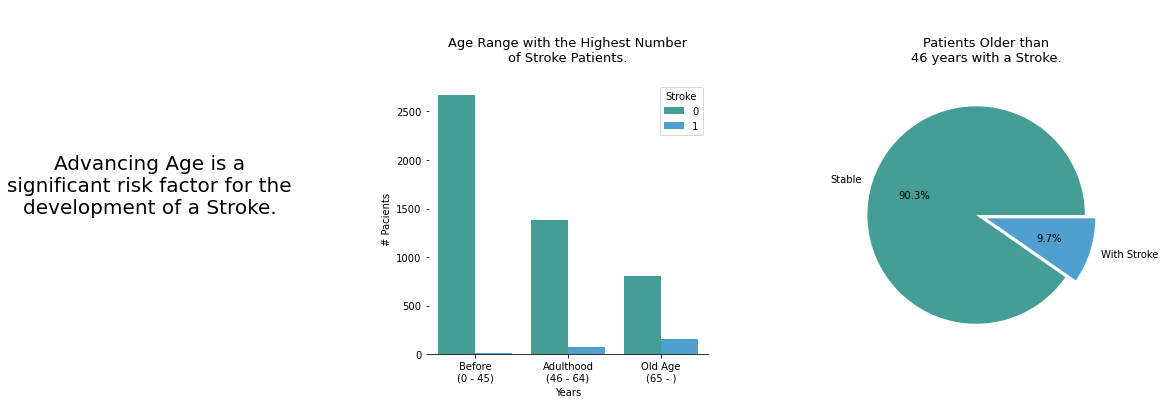

In [14]:
# DF of patients categorized by age range.
df_eda['age_range'] = pd.cut(df_eda['age'], bins=[0, 46, 65, np.inf], include_lowest=True,
                             labels=["Before\n(0 - 45)", "Adulthood\n(46 - 64)", "Old Age\n(65 - )"])

df_eda['old_age'] = pd.cut(df_eda['age'], bins=[0, 46, np.inf], include_lowest=True,
                             labels=["Before", "Adulthood & Old Age"])

# Old Age.
op = len(df_eda.loc[(df_eda['old_age'] == "Adulthood & Old Age") & (df_eda['stroke'] == 0)])
op_stroke = len(df_eda.loc[(df_eda['old_age'] == "Adulthood & Old Age") & (df_eda['stroke'] == 1)])
op_total = len(df_eda.loc[(df_eda['old_age'] == "Adulthood & Old Age")])
op = round((op / op_total) * 100, 2)
op_stroke = round((op_stroke / op_total) * 100, 2)
patients_op = [op, op_stroke]

# Plot
fig = plt.figure(figsize=(20,5))
gs = fig.add_gridspec(1,3)
gs.update(wspace=0.5)

# Plot Title
ax0 = fig.add_subplot(gs[0,0])
ax0.text(0.5,0.5,'Advancing Age is a\nsignificant risk factor for the\ndevelopment of a Stroke.\n\n\n',
         fontsize=20, horizontalalignment='center', verticalalignment='center')
ax0.spines[["bottom", "top", "left", "right"]].set_visible(False)
ax0.tick_params(left=False, bottom=False)
ax0.set_xticklabels([])
ax0.set_yticklabels([])

# Plot
ax1 = fig.add_subplot(gs[0,1])
ax1 = sns.countplot(df_eda['age_range'], hue=df_eda['stroke'], palette=palette)
ax1.set_title(f"\n\nAge Range with the Highest Number\nof Stroke Patients.\n", fontsize=13)
ax1.legend(title='Stroke')
ax1.spines[['top', 'right', 'left']].set_visible(False)
ax1.set_xlabel('Years')
ax1.set_ylabel('# Pacients')

# Plot With.
ax2 = fig.add_subplot(gs[0, 2])
ax2 = plt.pie(patients_op, labels = ['Stable', 'With Stroke'], autopct='%1.1f%%', explode=[0.1, 0], colors = ['#449E95', '#509FCF'])
plt.title("Patients Older than\n46 years with a Stroke.\n", fontsize=13)

plt.show()

<div class="alert alert-success" role="alert">
  <p> üîé Features like "Hypertension" and "Heart Disease" are very unbalanced.</p>
  <p> üîé Features like "Gender" and "Work Type" have categories with less than 0% of the data.</p>
  <p> üîé "Smoking Status" Feature se desconoce el status del 35% de los pacientes (categoria "Unknown"). </p>
  <p> </p>
</div>

### 4.1.2 Patients with an Advanced Age and with a BMI have a higher risk of having Stroke.

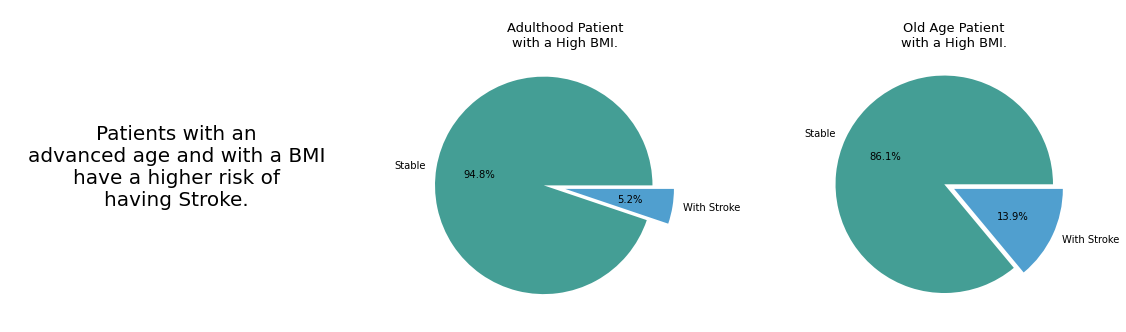

In [15]:
# DF of Patients categorized by their high BMI
df_eda['high BMI'] = pd.cut(df_eda['bmi'], bins=[0, 18.5, 24.9, np.inf], include_lowest=True,
                            labels=["Below Average", "Normal", "High BMI"])

# Adulthood.
adul_h_AgeBMI = len(df_eda.loc[(df_eda['age_range'] == 'Adulthood\n(46 - 64)') & (df_eda['high BMI'] == 'High BMI') & (df_eda['stroke'] == 0)])
adul_h_AgeBMI_stroke = len(df_eda.loc[(df_eda['age_range'] == 'Adulthood\n(46 - 64)') & (df_eda['high BMI'] == 'High BMI') & (df_eda['stroke'] == 1)])
adul_h_AgeBMI_total = len(df_eda.loc[(df_eda['age_range'] == 'Adulthood\n(46 - 64)') & (df_eda['high BMI'] == 'High BMI')])
adul_h_AgeBMI = round((adul_h_AgeBMI / adul_h_AgeBMI_total) * 100, 2)
adul_h_AgeBMI_stroke = round((adul_h_AgeBMI_stroke / adul_h_AgeBMI_total) * 100, 2)
pacients_adul_h_AgeBMI_total = [adul_h_AgeBMI, adul_h_AgeBMI_stroke]

# Old Age.
old_h_AgeBMI = len(df_eda.loc[(df_eda['age_range'] == 'Old Age\n(65 - )') & (df_eda['high BMI'] == 'High BMI') & (df_eda['stroke'] == 0)])
old_h_AgeBMI_stroke = len(df_eda.loc[(df_eda['age_range'] == 'Old Age\n(65 - )') & (df_eda['high BMI'] == 'High BMI') & (df_eda['stroke'] == 1)])
old_h_AgeBMI_total = len(df_eda.loc[(df_eda['age_range'] == 'Old Age\n(65 - )') & (df_eda['high BMI'] == 'High BMI')])
old_h_AgeBMI = round((old_h_AgeBMI / old_h_AgeBMI_total) * 100, 2)
old_h_AgeBMI_stroke = round((old_h_AgeBMI_stroke / old_h_AgeBMI_total) * 100, 2)
pacients_old_h_AgeBMI = [old_h_AgeBMI, old_h_AgeBMI_stroke]

# Plot
fig = plt.figure(figsize=(20,5))
gs = fig.add_gridspec(1,3)
gs.update(wspace=0.15)

# Plot Title
ax0 = fig.add_subplot(gs[0,0])
ax0.text(0.5,0.5,'Patients with an\nadvanced age and with a BMI\nhave a higher risk of\nhaving Stroke.\n\n',
         fontsize=20, horizontalalignment='center', verticalalignment='center')
ax0.spines[["bottom", "top", "left", "right"]].set_visible(False)
ax0.tick_params(left=False, bottom=False)
ax0.set_xticklabels([])
ax0.set_yticklabels([])

# Plot Adulthood.
ax1 = fig.add_subplot(gs[0,1])
ax1 = plt.pie(pacients_adul_h_AgeBMI_total, labels = ['Stable', 'With Stroke'], autopct='%1.1f%%', explode=[0.2, 0], colors = ['#449E95', '#509FCF'])
plt.title("\nAdulthood Patient\nwith a High BMI.", fontsize=13)

# Plot Old.
ax0 = fig.add_subplot(gs[0,2])
ax0 = plt.pie(pacients_old_h_AgeBMI, labels = ['Stable', 'With Stroke'], autopct='%1.1f%%', explode=[0.1, 0], colors = ['#449E95', '#509FCF'])
plt.title("\nOld Age Patient\nwith a High BMI.", fontsize=13)

plt.show()

<div class="alert alert-success" role="alert">
  <p> üîé Features like "Hypertension" and "Heart Disease" are very unbalanced.</p>
  <p> üîé Features like "Gender" and "Work Type" have categories with less than 0% of the data.</p>
  <p> üîé "Smoking Status" Feature se desconoce el status del 35% de los pacientes (categoria "Unknown"). </p>
  <p> </p>
</div>

### 4.1.3 Smokers with a high BMI have a higher risk of having a Stroke.

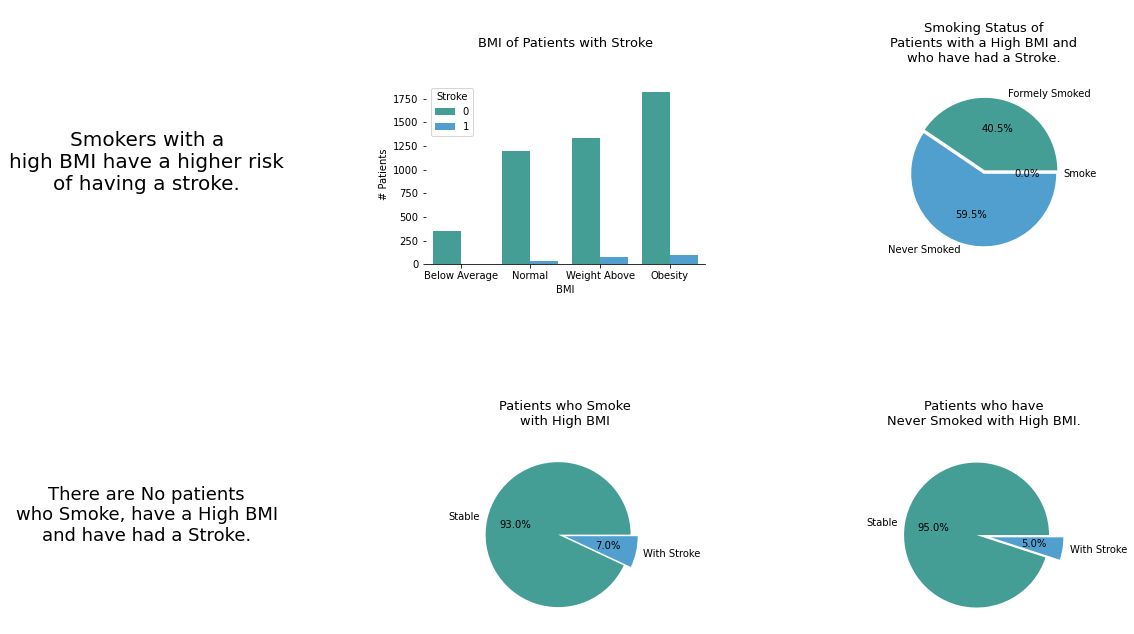

In [16]:
# DF of Patients categorized by their BMI
df_eda['bmi_cat'] = pd.cut(df_eda['bmi'], bins=[0, 18.5, 24.9, 29.9, np.inf], include_lowest=True,
                            labels=["Below Average", "Normal", "Weight Above", "Obesity"])                           

# Smoke Status Stroke.
smokes_stroke_len = len(df_eda.loc[(df_eda['smoking_status'] == 'smoke') & (df_eda['high BMI'] == 'High BMI') & (df_eda['stroke'] == 1)])
f_smokes_stroke_len = len(df_eda.loc[(df_eda['smoking_status'] == 'formerly smoked') & (df_eda['high BMI'] == 'High BMI') & (df_eda['stroke'] == 1)])
no_smokes_stroke_len = len(df_eda.loc[(df_eda['smoking_status'] == 'never smoked') & (df_eda['high BMI'] == 'High BMI') & (df_eda['stroke'] == 1)])

# Formerly Smokes.
f_smokes = len(df_eda.loc[(df_eda['smoking_status'] == 'formerly smoked') & (df_eda['high BMI'] == 'High BMI') & (df_eda['stroke'] == 0)])
f_smokes_stroke = len(df_eda.loc[(df_eda['smoking_status'] == 'formerly smoked') & (df_eda['high BMI'] == 'High BMI') & (df_eda['stroke'] == 1)])
f_smokes_total = len(df_eda.loc[(df_eda['smoking_status'] == 'formerly smoked') & (df_eda['high BMI'] == 'High BMI')])
f_smokes = round((f_smokes / f_smokes_total) * 100, 2)
f_smokes_stroke = round((f_smokes_stroke / f_smokes_total) * 100, 2)
f_smoke_highBMI = [f_smokes, f_smokes_stroke]

# No Smokes.
no_smokes = len(df_eda.loc[(df_eda['smoking_status'] == 'never smoked') & (df_eda['high BMI'] == 'High BMI') & (df_eda['stroke'] == 0)])
no_smokes_stroke = len(df_eda.loc[(df_eda['smoking_status'] == 'never smoked') & (df_eda['high BMI'] == 'High BMI') & (df_eda['stroke'] == 1)])
no_smokes_total = len(df_eda.loc[(df_eda['smoking_status'] == 'never smoked') & (df_eda['high BMI'] == 'High BMI')])
no_smoke = round((no_smokes / no_smokes_total) * 100, 2)
no_smokes_stroke = round((no_smokes_stroke / no_smokes_total) * 100, 2)
no_smoke_highBMI = [no_smoke, no_smokes_stroke]

# Plots
fig = plt.figure(figsize=(20,10))
gs = fig.add_gridspec(2,3)
gs.update(wspace=0.5, hspace=1)

# Plot Title High BMI
ax0 = fig.add_subplot(gs[0,0])
ax0.text(0.5,0.5,'\nSmokers with a\nhigh BMI have a higher risk\nof having a stroke.\n\n',
         fontsize=20, horizontalalignment='center', verticalalignment='center')
ax0.spines[["bottom", "top", "left", "right"]].set_visible(False)
ax0.tick_params(left=False, bottom=False)
ax0.set_xticklabels([])
ax0.set_yticklabels([])

# Plot
ax1 = fig.add_subplot(gs[0,1])
ax1 = sns.countplot(df_eda['bmi_cat'], hue=df_eda['stroke'], palette=palette)
ax1.set_title(f"\nBMI of Patients with Stroke\n\n", fontsize=13)
ax1.legend(title='Stroke')
ax1.spines[['top', 'right', 'left']].set_visible(False)
ax1.set_xlabel('BMI')
ax1.set_ylabel('# Patients')

# Plot Smoke Status Stroke.
ax2 = fig.add_subplot(gs[0,2])
ax2 = plt.pie([smokes_stroke_len,f_smokes_stroke_len, no_smokes_stroke_len], autopct='%1.1f%%', explode=[0, 0.05, 0],
              labels = ['Smoke', 'Formely Smoked', 'Never Smoked'], colors = ['#D37EE3', '#449E95', '#509FCF'])
plt.title("\nSmoking Status of\nPatients with a High BMI and\nwho have had a Stroke.\n", fontsize=13)

# Plot Title Smoke
ax3 = fig.add_subplot(gs[1,0])
ax3.text(0.5,0.5,'There are No patients\nwho Smoke, have a High BMI\nand have had a Stroke.\n\n',
         fontsize=18, horizontalalignment='center', verticalalignment='center')
ax3.spines[["bottom", "top", "left", "right"]].set_visible(False)
ax3.tick_params(left=False, bottom=False)
ax3.set_xticklabels([])
ax3.set_yticklabels([])

# Plot Formerly Smokes.
ax4 = fig.add_subplot(gs[1,1])
ax4 = plt.pie(f_smoke_highBMI, labels = ['Stable', 'With Stroke'], autopct='%1.1f%%', explode=[0.1, 0], colors = ['#449E95', '#509FCF'])
plt.title("\nPatients who Smoke\nwith High BMI\n", fontsize=13)

# Plot No Smokes.
ax5 = fig.add_subplot(gs[1,2])
ax5 = plt.pie(no_smoke_highBMI, labels = ['Stable', 'With Stroke'], autopct='%1.1f%%', explode=[0.1, 0.1], colors = ['#449E95', '#509FCF'])
plt.title("\nPatients who have\nNever Smoked with High BMI.\n", fontsize=13)

plt.show()

<div class="alert alert-success" role="alert">
  <p> üîé Features like "Hypertension" and "Heart Disease" are very unbalanced.</p>
  <p> üîé Features like "Gender" and "Work Type" have categories with less than 0% of the data.</p>
  <p> üîé "Smoking Status" Feature se desconoce el status del 35% de los pacientes (categoria "Unknown"). </p>
  <p> </p>
</div>

### 4.1.4 Patients with Hypertension and Heart Disease are more likely to have a Stroke compared to those without these conditions.

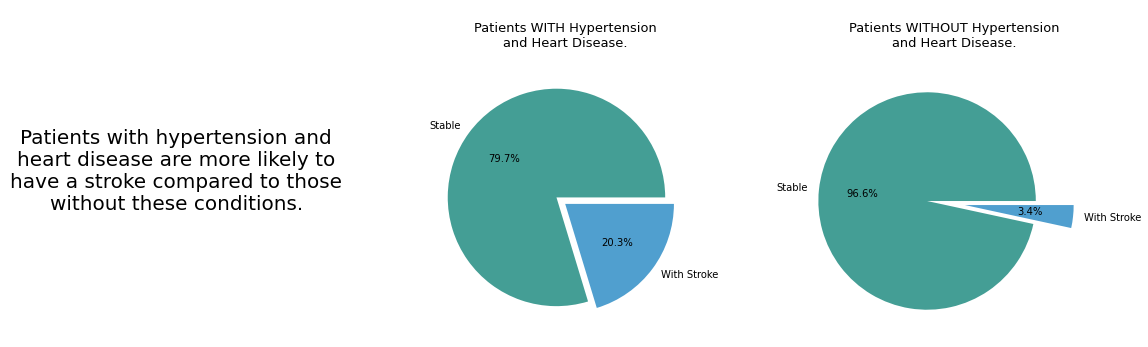

In [17]:
# With.
with_hh = len(df_eda.loc[(df_eda['hypertension'] == 1) & (df_eda['heart_disease'] == 1) & (df_eda['stroke'] == 0)])
with_hh_stroke = len(df_eda.loc[(df_eda['hypertension'] == 1) & (df_eda['heart_disease'] == 1) & (df_eda['stroke'] == 1)])
with_hh_total = len(df_eda.loc[(df_eda['hypertension'] == 1) & (df_eda['heart_disease'] == 1)])
with_hh = round((with_hh / with_hh_total) * 100, 2)
with_hh_stroke = round((with_hh_stroke / with_hh_total) * 100, 2)
patients_with_hh = [with_hh, with_hh_stroke]

# Without.
without_hh = len(df_eda.loc[(df_eda['hypertension'] == 0) & (df_eda['heart_disease'] == 0) & (df_eda['stroke'] == 0)])
without_hh_stroke = len(df_eda.loc[(df_eda['hypertension'] == 0) & (df_eda['heart_disease'] == 0) & (df_eda['stroke'] == 1)])
without_hh_total = len(df_eda.loc[(df_eda['hypertension'] == 0) & (df_eda['heart_disease'] == 0)])
without_hh = round((without_hh / without_hh_total) * 100, 2)
without_hh_stroke = round((without_hh_stroke / without_hh_total) * 100, 2)
patients_without_hh = [without_hh, without_hh_stroke]

# Plot
fig = plt.figure(figsize=(20,5))
gs = fig.add_gridspec(1,3)
gs.update(wspace=0.15)

# Plot Title
ax0 = fig.add_subplot(gs[0,0])
ax0.text(0.5,0.5,'Patients with hypertension and\nheart disease are more likely to\nhave a stroke compared to those\nwithout these conditions.\n\n\n',
         fontsize=20, horizontalalignment='center', verticalalignment='center')
ax0.spines[["bottom", "top", "left", "right"]].set_visible(False)
ax0.tick_params(left=False, bottom=False)
ax0.set_xticklabels([])
ax0.set_yticklabels([])

# Plot With.
ax1 = fig.add_subplot(gs[0,1])
ax1 = plt.pie(patients_with_hh, labels = ['Stable', 'With Stroke'], autopct='%1.1f%%', explode=[0.1, 0], colors = ['#449E95', '#509FCF'])
plt.title("\nPatients WITH Hypertension\nand Heart Disease.\n", fontsize=13)

# Plot Without.
ax0 = fig.add_subplot(gs[0,2])
ax0 = plt.pie(patients_without_hh, labels = ['Stable', 'With Stroke'], autopct='%1.1f%%', explode=[0.25, 0.1], colors = ['#449E95', '#509FCF'])
plt.title("\nPatients WITHOUT Hypertension\nand Heart Disease.\n", fontsize=13)

plt.show()

<div class="alert alert-success" role="alert">
  <p> üîé Features like "Hypertension" and "Heart Disease" are very unbalanced.</p>
  <p> üîé Features like "Gender" and "Work Type" have categories with less than 0% of the data.</p>
  <p> üîé "Smoking Status" Feature se desconoce el status del 35% de los pacientes (categoria "Unknown"). </p>
  <p> </p>
</div>

### 4.1.5 Patients with elevated Blood Glucose levels have a higher risk of suffering a Stroke compared to those with Normal Glucose Levels.

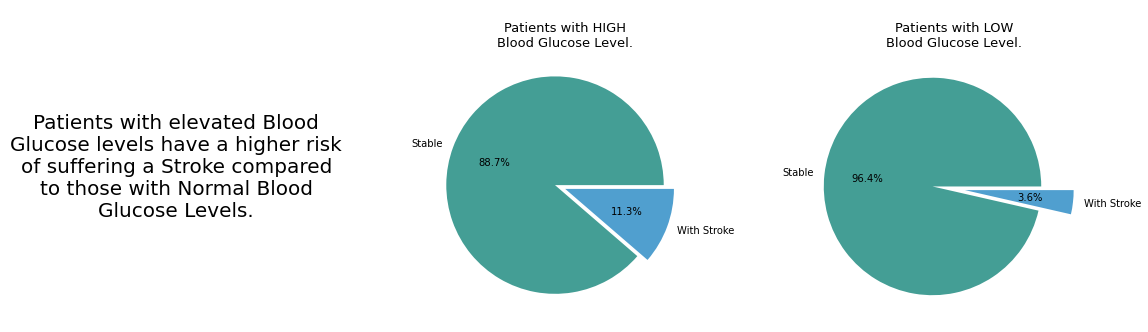

In [18]:
df_eda['avg_gluc_lvl_range'] = pd.cut(df_eda['avg_glucose_level'], bins=[0, 70, 140, np.inf], include_lowest=True,
                                          labels=["Low Level", "Normal Level", "High Level"])

# High
high = len(df_eda.loc[(df_eda['avg_gluc_lvl_range'] == 'High Level') & (df_eda['stroke'] == 0)])
high_stroke =  len(df_eda.loc[(df_eda['avg_gluc_lvl_range'] == 'High Level') & (df_eda['stroke'] == 1)])
high_total = len(df_eda.loc[(df_eda['avg_gluc_lvl_range'] == 'High Level')])
high = round((high / high_total) * 100, 2)
high_stroke = round((high_stroke / high_total) * 100, 2)
patients_high = [high, high_stroke]

# Low
low = len(df_eda.loc[(df_eda['avg_gluc_lvl_range'] == 'Low Level') & (df_eda['stroke'] == 0)])
low_stroke = len(df_eda.loc[(df_eda['avg_gluc_lvl_range'] == 'Low Level') & (df_eda['stroke'] == 1)])
low_total = len(df_eda.loc[(df_eda['avg_gluc_lvl_range'] == 'Low Level')])
low = round((low / low_total) * 100, 2)
low_stroke = round((low_stroke / low_total) * 100, 2)
patients_low = [low, low_stroke]

# Plot
fig = plt.figure(figsize=(20,5))
gs = fig.add_gridspec(1,3)
gs.update(wspace=0.15)

# Plot Title
ax0 = fig.add_subplot(gs[0,0])
ax0.text(0.5,0.5,'Patients with elevated Blood\nGlucose levels have a higher risk\nof suffering a Stroke compared\nto those with Normal Blood\nGlucose Levels.\n\n',
         fontsize=20, horizontalalignment='center', verticalalignment='center')
ax0.spines[["bottom", "top", "left", "right"]].set_visible(False)
ax0.tick_params(left=False, bottom=False)
ax0.set_xticklabels([])
ax0.set_yticklabels([])

# Plot High.
ax1 = fig.add_subplot(gs[0,1])
ax1 = plt.pie(patients_high, labels = ['Stable', 'With Stroke'], autopct='%1.1f%%', explode=[0.1, 0], colors = ['#449E95', '#509FCF'])
plt.title("\nPatients with HIGH\nBlood Glucose Level.", fontsize=13)

# Plot Low.
ax0 = fig.add_subplot(gs[0,2])
ax0 = plt.pie(patients_low, labels = ['Stable', 'With Stroke'], autopct='%1.1f%%', explode=[0.20, 0.1], colors = ['#449E95', '#509FCF'])
plt.title("\nPatients with LOW\nBlood Glucose Level.", fontsize=13)

plt.show()

<div class="alert alert-success" role="alert">
  <p> üîé Features like "Hypertension" and "Heart Disease" are very unbalanced.</p>
  <p> üîé Features like "Gender" and "Work Type" have categories with less than 0% of the data.</p>
  <p> üîé "Smoking Status" Feature se desconoce el status del 35% de los pacientes (categoria "Unknown"). </p>
  <p> </p>
</div>

### 4.1.6 People who live in Urban Areas are at Higher risk of having a Stroke than those who live in Rural Areas.

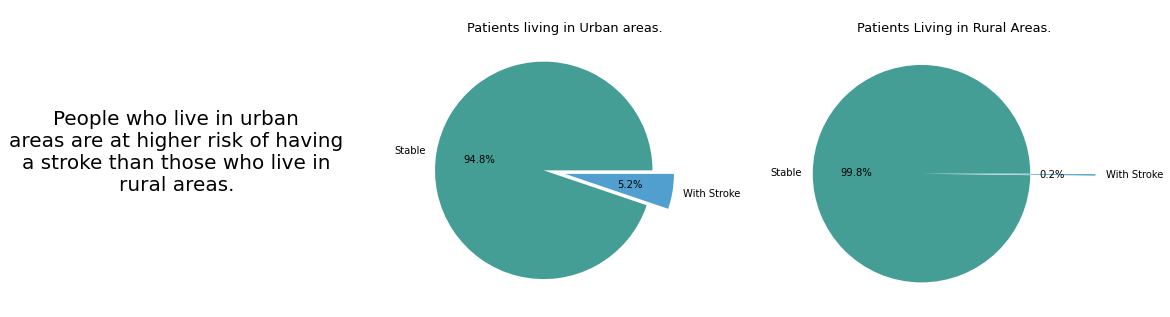

In [19]:
# Urban
urban = len(df_eda.loc[(df_eda['Residence_type'] == 'Urban') & (df_eda['stroke'] == 0)])
urban_stroke =  len(df_eda.loc[(df_eda['Residence_type'] == 'Urban') & (df_eda['stroke'] == 1)])
urban_total = len(df_eda.loc[(df_eda['Residence_type'] == 'Urban')])
urban = round((urban / urban_total) * 100, 2)
urban_stroke = round((urban_stroke / urban_total) * 100, 2)
patients_urban = [urban, urban_stroke]

# Rural
rural = len(df_eda.loc[(df_eda['Residence_type'] == 'Rural') & (df_eda['stroke'] == 0)])
rural_stroke =  len(df_eda.loc[(df_eda['Residence_type'] == 'Rural') & (df_eda['stroke'] == 1)])
rural_total = len(df_eda.loc[(df_eda['Residence_type'] == 'Rural')])
rural = round((rural / rural_total) * 100, 2)
rural_stroke = round((urban_stroke / rural_total) * 100, 2)
patients_rural = [rural, rural_stroke]


# Plot
fig = plt.figure(figsize=(20,5))
gs = fig.add_gridspec(1,3)
gs.update(wspace=0.15)

# Plot Title
ax0 = fig.add_subplot(gs[0,0])
ax0.text(0.5,0.5,'People who live in urban\nareas are at higher risk of having\na stroke than those who live in\nrural areas.\n\n',
         fontsize=20, horizontalalignment='center', verticalalignment='center')
ax0.spines[["bottom", "top", "left", "right"]].set_visible(False)
ax0.tick_params(left=False, bottom=False)
ax0.set_xticklabels([])
ax0.set_yticklabels([])

# Plot Urban.
ax1 = fig.add_subplot(gs[0,1])
ax1 = plt.pie(patients_urban, labels = ['Stable', 'With Stroke'], autopct='%1.1f%%', explode=[0.2, 0], colors = ['#449E95', '#509FCF'])
plt.title("\nPatients living in Urban areas.", fontsize=13)

# Plot Rural.
ax0 = fig.add_subplot(gs[0,2])
ax0 = plt.pie(patients_rural, labels = ['Stable', 'With Stroke'], autopct='%1.1f%%', explode=[0.3, 0.3], colors = ['#449E95', '#509FCF'])
plt.title("\nPatients Living in Rural Areas.", fontsize=13)

plt.show()

<div class="alert alert-success" role="alert">
  <p> üîé Features like "Hypertension" and "Heart Disease" are very unbalanced.</p>
  <p> üîé Features like "Gender" and "Work Type" have categories with less than 0% of the data.</p>
  <p> üîé "Smoking Status" Feature se desconoce el status del 35% de los pacientes (categoria "Unknown"). </p>
  <p> </p>
</div>

### 4.1.7. Married Men are at higher risk of having a Stroke than those who are Not Married.

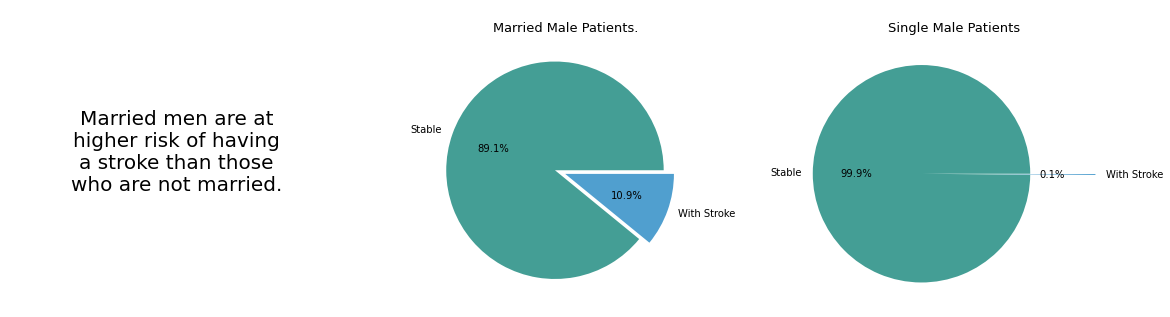

In [20]:
# Married
married = len(df_eda.loc[(df_eda['gender'] == 'Male') & (df_eda['ever_married'] == 'Yes') & (df_eda['stroke'] == 0)])
married_stroke =  len(df_eda.loc[(df_eda['gender'] == 'Male') & (df_eda['ever_married'] == 'Yes') & (df_eda['stroke'] == 1)])
married_total = len(df_eda.loc[(df_eda['gender'] == 'Male') & (df_eda['ever_married'] == 'Yes')])

married = round((married / married_total) * 100, 2)
married_stroke = round((married_stroke / married_total) * 100, 2)
patients_married = [married, high_stroke]

# No Married
no_married = len(df_eda.loc[(df_eda['gender'] == 'Male') & (df_eda['ever_married'] == 'No') & (df_eda['stroke'] == 0)])
no_married_stroke =  len(df_eda.loc[(df_eda['gender'] == 'Male') & (df_eda['ever_married'] == 'No') & (df_eda['stroke'] == 1)])
no_married_total = len(df_eda.loc[(df_eda['gender'] == 'Male') & (df_eda['ever_married'] == 'No')])

no_dmarried = round((no_married / no_married_total) * 100, 2)
no_married_stroke = round((no_married_stroke / no_married_total) * 100, 2)
patients_no_married = [no_married, no_married_stroke]

# Plot
fig = plt.figure(figsize=(20,5))
gs = fig.add_gridspec(1,3)
gs.update(wspace=0.15)

# Plot Title
ax0 = fig.add_subplot(gs[0,0])
ax0.text(0.5,0.5,'Married men are at\nhigher risk of having\na stroke than those\nwho are not married.\n\n',
         fontsize=20, horizontalalignment='center', verticalalignment='center')
ax0.spines[["bottom", "top", "left", "right"]].set_visible(False)
ax0.tick_params(left=False, bottom=False)
ax0.set_xticklabels([])
ax0.set_yticklabels([])

# Plot High.
ax1 = fig.add_subplot(gs[0,1])
ax1 = plt.pie(patients_married, labels = ['Stable', 'With Stroke'], autopct='%1.1f%%', explode=[0.1, 0], colors = ['#449E95', '#509FCF'])
plt.title("\nMarried Male Patients.", fontsize=13)

# Plot Low.
ax0 = fig.add_subplot(gs[0,2])
ax0 = plt.pie(patients_no_married, labels = ['Stable', 'With Stroke'], autopct='%1.1f%%', explode=[0.3, 0.3], colors = ['#449E95', '#509FCF'])
plt.title("\nSingle Male Patients", fontsize=13)

plt.show()

<div class="alert alert-success" role="alert">
  <p> üîé Features like "Hypertension" and "Heart Disease" are very unbalanced.</p>
  <p> üîé Features like "Gender" and "Work Type" have categories with less than 0% of the data.</p>
  <p> üîé "Smoking Status" Feature se desconoce el status del 35% de los pacientes (categoria "Unknown"). </p>
  <p> </p>
</div>

---
## 4.2 Univariate Analysis.
### 4.2.1 Analysis of Categorical Features.

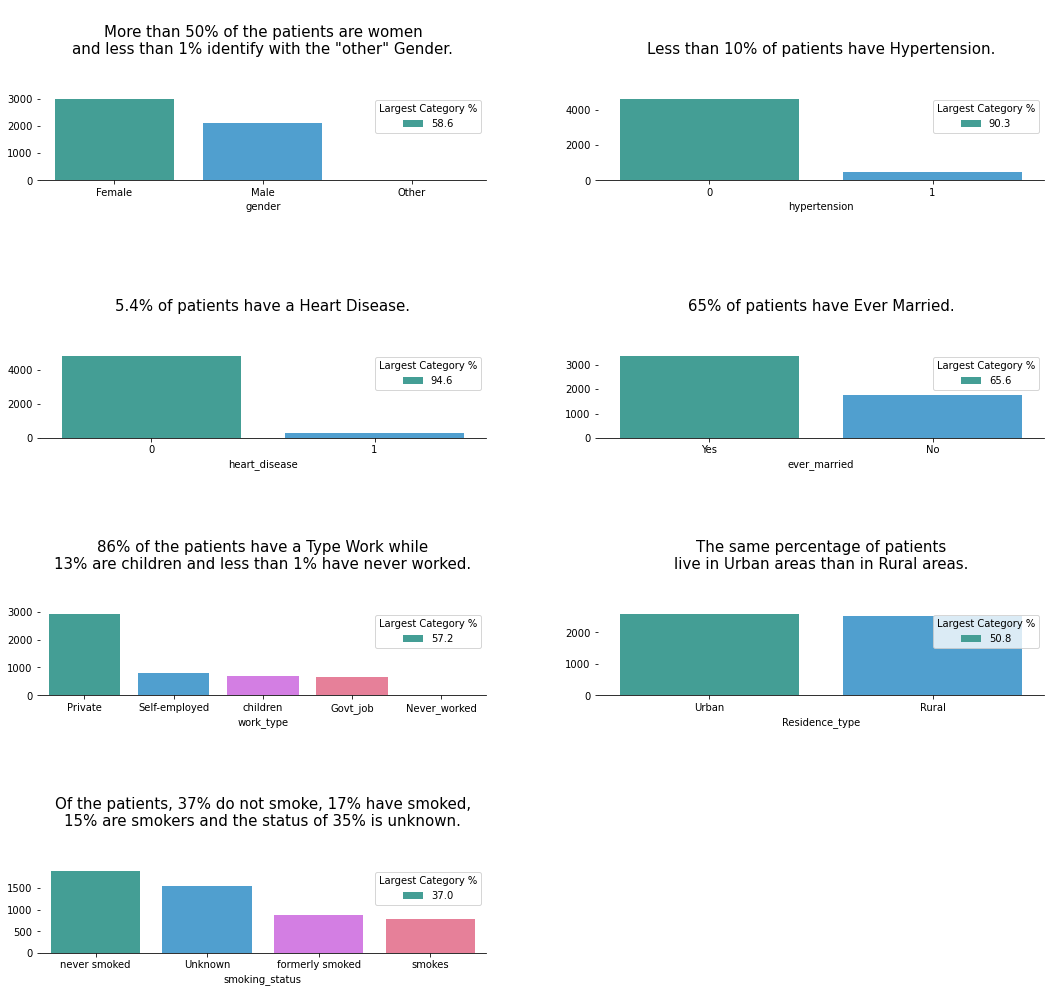

In [21]:
# Plot Description.
description = [str(f'\nMore than 50% of the patients are women\nand less than 1% identify with the "other" Gender.\n\n'),
               str(f'Less than 10% of patients have Hypertension.\n\n'),
               str(f'5.4% of patients have a Heart Disease.\n\n'),
               str(f'65% of patients have Ever Married.\n\n'),
               str(f'86% of the patients have a Type Work while\n13% are children and less than 1% have never worked.\n\n'),
               str(f'The same percentage of patients\nlive in Urban areas than in Rural areas.\n\n'),
               str(f'Of the patients, 37% do not smoke, 17% have smoked,\n15% are smokers and the status of 35% is unknown.\n\n')]

# Grid Plot.
fig = plt.figure(figsize=(18,30))
gs =  gridspec.GridSpec(7,2)
gs.update(wspace=0.25, hspace=2.0)

# With a loop, we assign each feature a consecutive number.
for i, j in enumerate(features_cat.values):
    ax = plt.subplot(gs[i])
    sns.countplot(df[j], palette=palette, order=[x for x in df[j].value_counts().index])
    ax.set_title(description[i], fontsize=15)
    ax.legend([((x/len(df)*100).round(1)) for x in df[j].value_counts().values], title='Largest Category %')
    ax.spines[['top', 'right', 'left']].set_visible(False)
    ax.set_xlabel(str(j))
    ax.set_ylabel('')
plt.show()

<div class="alert alert-success" role="alert">
  <p> üîé Features like "Hypertension" and "Heart Disease" are very unbalanced.</p>
  <p> üîé Features like "Gender" and "Work Type" have categories with less than 0% of the data.</p>
  <p> üîé "Smoking Status" Feature se desconoce el status del 35% de los pacientes (categoria "Unknown"). </p>
  <p> </p>
</div>

### 4.2.2 Analysis of Numerical Features.

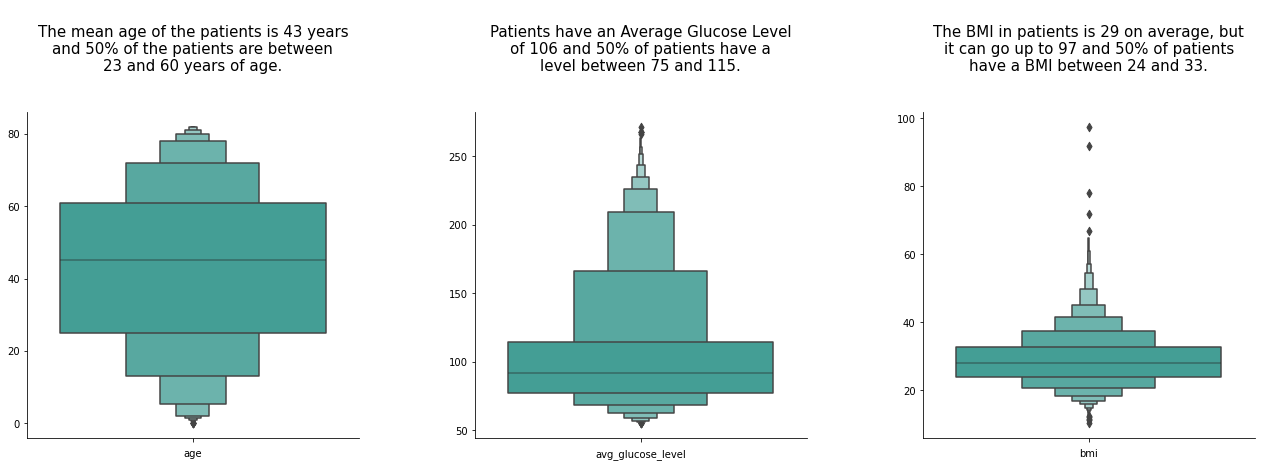

In [22]:
# Plot Description.
description = [str(f'\nThe mean age of the patients is 43 years\nand 50% of the patients are between\n23 and 60 years of age.\n\n'),
               str(f'Patients have an Average Glucose Level\nof 106 and 50% of patients have a\nlevel between 75 and 115.\n\n'),
               str(f'The BMI in patients is 29 on average, but\nit can go up to 97 and 50% of patients\nhave a BMI between 24 and 33.\n\n')]

# Grid Plot.
fig = plt.figure(figsize=(22,6))
gs = gridspec.GridSpec(1,3)
gs.update(wspace=0.35)

# With a loop, we assign each feature a consecutive number.
for i, j in enumerate(features_num.values):
    ax = plt.subplot(gs[i])
    sns.boxenplot(y=df[j], palette=palette)
    ax.set_title(description[i], fontsize=15)
    ax.spines[['top', 'right']].set_visible(False)
    ax.set_xlabel(str(j))
    ax.set_ylabel('')
plt.show()

<div class="alert alert-success" role="alert">
  <p> üîé The "Age" Feature has a gaussian distribution.</p>
  <p> üîé The Features "AVG Glucose Level" and "BMI" have a right-skewed distribution.</p>
  <p> üîé All the features have outliers but "BMI" is the one with the most marked ones.</p>
  <p> </p>
</div>

### 4.2.3 Target Analysis.

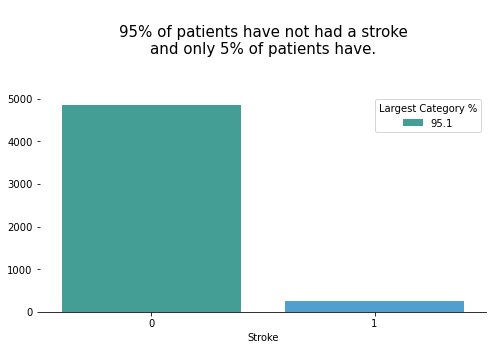

In [23]:
# Plot.
fig, ax = plt.subplots(figsize=(8, 4))
ax= sns.countplot(target, palette=palette)
ax.set_title(f"\n95% of patients have not had a stroke\nand only 5% of patients have.\n\n", fontsize=15)
ax.legend((target.value_counts()/len(df)*100).round(1), title='Largest Category %')
ax.spines[['top', 'right', 'left']].set_visible(False)
ax.set_xlabel('Stroke')
ax.set_ylabel('')
plt.show()

<div class="alert alert-success" role="alert">
  <p> üîé The data of the patients who have had a stroke are unbalanced.</p>
  <p> üîé The "Stroke" feature is the label that will be used for the classification model.</p>
  <p> üîé The imbalance directly affects the generalization capacity of the classifier since it assumes that the sample sets per class are balanced.</p>
  <p> üîé The data will have to be balanced with a transformer like "Smote".</p>
  <p> </p>
</div>

---
## 4.3 Multivariate Analysis
### 4.3.1 Features Matrix Correlation

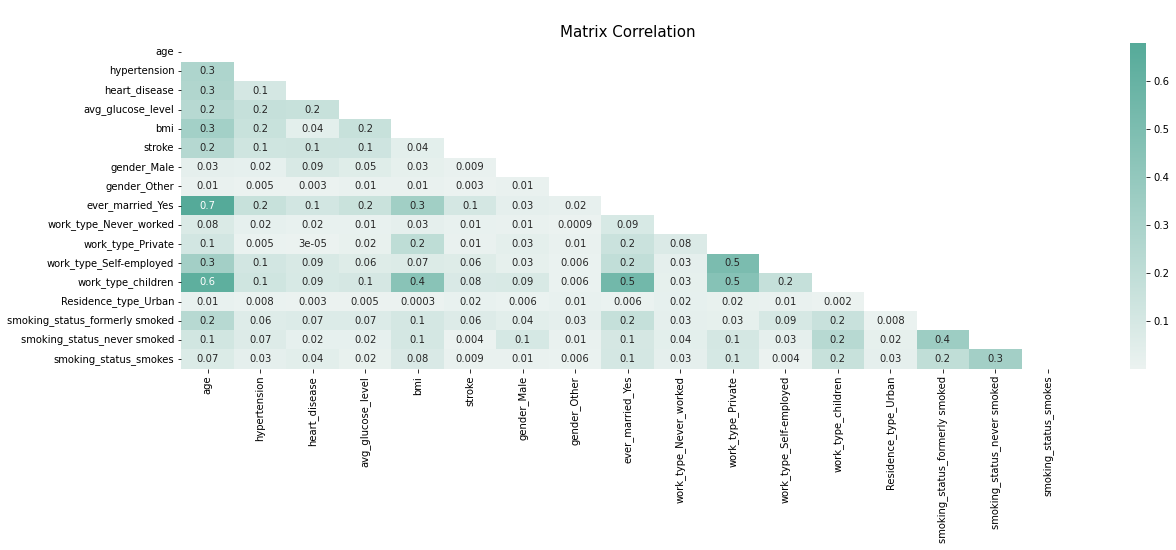

In [24]:
# DF Matrix Correlation.
df_corr = abs(df_encode.corr())

# Matrix Plot.
plt.subplots(figsize=(20,6))
sns.heatmap(df_corr, annot=True, fmt='.1g', cmap=palette_matrix, cbar=True, mask=np.triu(df_corr))
plt.title('\nMatrix Correlation', fontsize=15)
plt.show()

<div class="alert alert-success" role="alert">
  <p> üîé There is only one high correlation (greater than 0.7) in the crossing of the features "Age" with "Ever_Married_Yes".</p>
  <p> üîé There are 12 crosses between the Features with moderate correlations (in a range of 0.3 to 0.6)..</p>
  <p> üîé The rest of the crosses are of low correlations (less than 3).</p>
  <p> </p>
</div>

### 4.3.2 Higher and Less Correlation with the Target

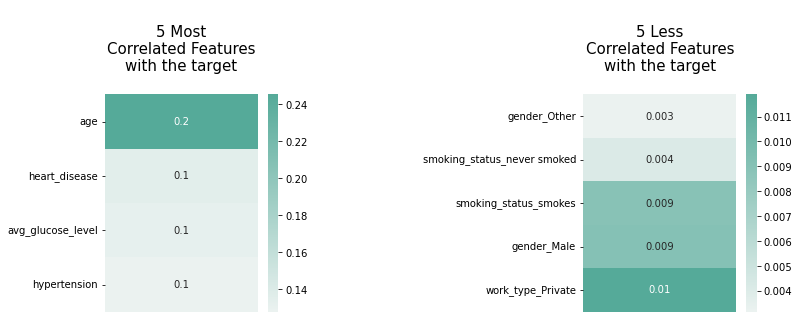

In [25]:
# DF with the features with the highest correlation and the target is removed.
corr_higher = pd.DataFrame(df_corr['stroke'].sort_values(ascending=False)).head()
corr_higher = corr_higher.drop('stroke', axis=0)

# DF with the features with less correlation.
corr_less = pd.DataFrame(df_corr['stroke'].sort_values()).head()

# List of DFs of Correlations
corr_ls = [corr_higher, corr_less]

# Plot Description.
description = [str(f'\n5 Most\nCorrelated Features\nwith the target\n'), str(f'5 Less\nCorrelated Features\nwith the target\n')]

# Grid Plot.
fig = plt.figure(figsize=(12,4))
gs = gridspec.GridSpec(1,2)
gs.update(wspace=1.5, hspace=0.35)

# With a loop, we assign each feature a consecutive number.
for i, j in enumerate(corr_ls):
    ax = plt.subplot(gs[i])
    sns.heatmap(corr_ls[i], annot=True, fmt='.1g', cmap=palette_matrix, cbar=True)
    ax.set_title(description[i], fontsize=15)
    ax.set_xlabel('')
    ax.set_xticklabels([])
    ax.tick_params(bottom=False)
plt.show()

<div class="alert alert-success" role="alert">
  <p> üîé "Age" is the feature that has the highest correlation with the target ("stroke") with a low correlation of 0.2.</p>
  <p> üîé "gender_Other" is the feature that has the least correlation with the target ("stroke")</p>
  <p> </p>
</div>

### 4.3.3 Target Distribution in Data.

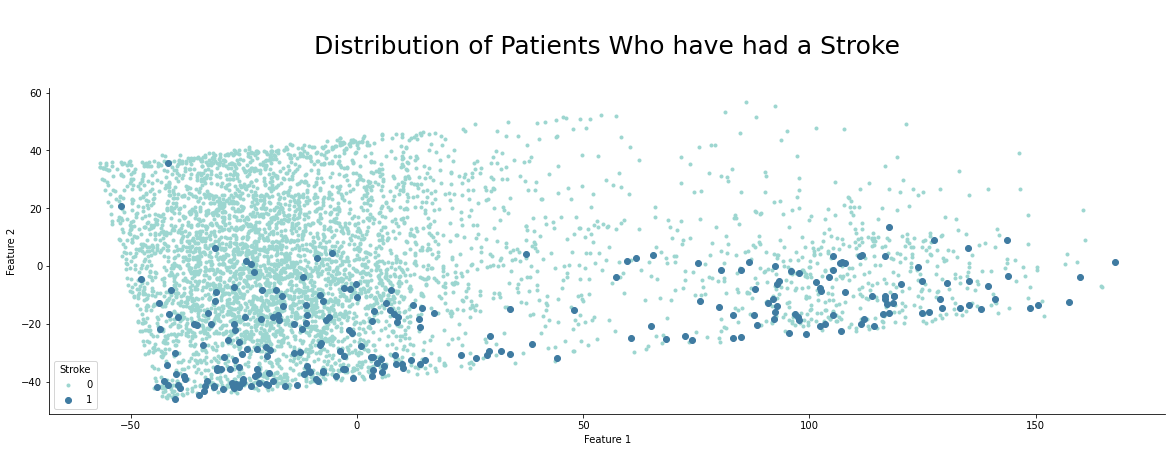

In [26]:
# Patients who have not had Stroke.
no_stroke = [df_reduce["feature_1"][df_reduce['stroke'] == 0], df_reduce["feature_2"][df_reduce['stroke'] == 0]]
# Patients who have had Stroke.
yes_stroke = [df_reduce["feature_1"][df_reduce['stroke'] == 1], df_reduce["feature_2"][df_reduce['stroke'] == 1]]

# Plot.
fig, ax = plt.subplots(figsize=(20, 6))
ax.scatter(no_stroke[0], no_stroke[1], c="#9CD6D0", marker=".") # Green
ax.scatter(yes_stroke[0], yes_stroke[1], c="#3F7BA1", marker="o") # Blue
ax.set_title(f"\nDistribution of Patients Who have had a Stroke\n", fontsize=25)
ax.legend(df['stroke'].value_counts().index, title="Stroke", loc="lower left")
ax.spines[['top', 'right']].set_visible(False)
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
plt.show()

<div class="alert alert-success" role="alert">
  <p> üîé Intuitions of the distribution for the model are obtained.</p>
  <p> </p>
</div>

## 4.3.4 Target Distribution in Features.

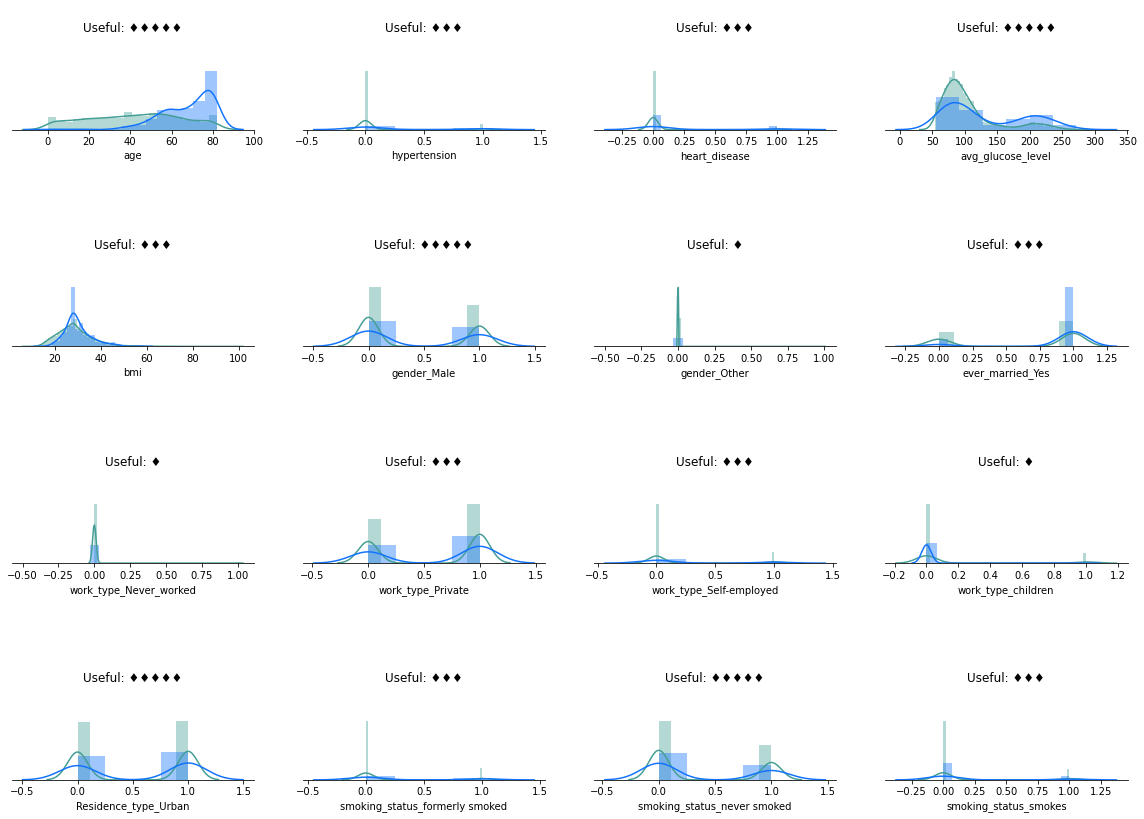

In [27]:
# Plot Description.
description = [str(f'\nUseful: ‚ô¶Ô∏è‚ô¶Ô∏è‚ô¶Ô∏è‚ô¶Ô∏è‚ô¶Ô∏è\n\n'), str(f'Useful: ‚ô¶Ô∏è‚ô¶Ô∏è‚ô¶Ô∏è\n\n'), str(f'Useful: ‚ô¶Ô∏è‚ô¶Ô∏è‚ô¶Ô∏è\n\n'), str(f'Useful: ‚ô¶Ô∏è‚ô¶Ô∏è‚ô¶Ô∏è‚ô¶Ô∏è‚ô¶Ô∏è\n\n'),
               str(f'Useful: ‚ô¶Ô∏è‚ô¶Ô∏è‚ô¶Ô∏è\n\n'), str(f'Useful: ‚ô¶Ô∏è‚ô¶Ô∏è‚ô¶Ô∏è‚ô¶Ô∏è‚ô¶Ô∏è\n\n'), str(f'Useful: ‚ô¶Ô∏è\n\n'), str(f'Useful: ‚ô¶Ô∏è‚ô¶Ô∏è‚ô¶Ô∏è\n\n'), str(f'Useful: ‚ô¶Ô∏è\n\n'),
               str(f'Useful: ‚ô¶Ô∏è‚ô¶Ô∏è‚ô¶Ô∏è\n\n'), str(f'Useful: ‚ô¶Ô∏è‚ô¶Ô∏è‚ô¶Ô∏è\n\n'), str(f'Useful: ‚ô¶Ô∏è\n\n'), str(f'Useful: ‚ô¶Ô∏è‚ô¶Ô∏è‚ô¶Ô∏è‚ô¶Ô∏è‚ô¶Ô∏è\n\n'), str(f'Useful: ‚ô¶Ô∏è‚ô¶Ô∏è‚ô¶Ô∏è\n\n'),
               str(f'Useful: ‚ô¶Ô∏è‚ô¶Ô∏è‚ô¶Ô∏è‚ô¶Ô∏è‚ô¶Ô∏è\n\n'), str(f'Useful: ‚ô¶Ô∏è‚ô¶Ô∏è‚ô¶Ô∏è\n\n'),]

# Plot.
plt.figure(figsize=(20,45))
gs = gridspec.GridSpec(12,4)
gs.update(hspace=2.5, wspace=.2)

# With a loop, we assign each feature a consecutive number.
for i, j in enumerate(features_encode):
    ax = plt.subplot(gs[i])
    sns.distplot(df_encode[j][df_encode['stroke']==0], color='#449E95') # Green
    sns.distplot(df_encode[j][df_encode['stroke']==1], color='#1273FC') # Blue
    ax.set_title(description[i], fontsize=12)
    ax.spines[['top', 'right', 'left']].set_visible(False)
    ax.set_xlabel(str(j))
    ax.set_ylabel('')
    ax.tick_params(left=False)
    ax.set_yticklabels([])

plt.show()

<div class="alert alert-success" role="alert">
  <p> üîé Institutions are obtained on the features that can most influence the classifier.</p>
  <p> üîé The 5 Features that can influence the model the most are "age", "bmi", "gender_Male", "Residence_type_Urban" and "smoking_status_never smoked".</p>
  <p> üîé The 3 Features that can least influence the model are "gender_Other", "work_type_Never_worked" and "work_type_children".</p>
  <p> </p>
</div>